# NLP with Disaster Tweets

In [2]:
#import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [5]:
# Show data files
import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data\sample_submission.csv
../data\test.csv
../data\train.csv


In [6]:
#load files:-
train  = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub=pd.read_csv('../data/sample_submission.csv')

In [7]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [8]:
train.isnull().sum(), test.isnull().sum()

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

In [9]:
# substitue NaN value here with mode

train['location'] = train['location'].fillna(train['location'].mode()[0])
train['keyword'] = train['keyword'].fillna(train['keyword'].mode()[0])

test['location'] = test['location'].fillna(test['location'].mode()[0])
test['keyword'] = test['keyword'].fillna(test['keyword'].mode()[0])

In [10]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

In [11]:
train.shape, test.shape

((7613, 5), (3263, 4))

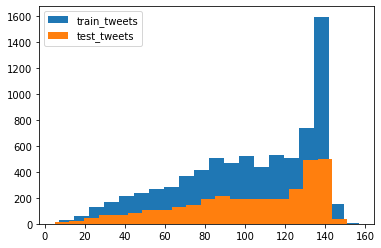

In [12]:
#compare tweets in train and test file
length_train=train['text'].str.len()
length_test=test['text'].str.len()
plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [13]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
percentage_disaster=(train.target.value_counts() / len(train.target)) * 100
percentage_disaster

0    57.034021
1    42.965979
Name: target, dtype: float64

In [15]:
label = train.groupby('target')['target'].sum()
label/len(train)*100

target
0     0.000000
1    42.965979
Name: target, dtype: float64

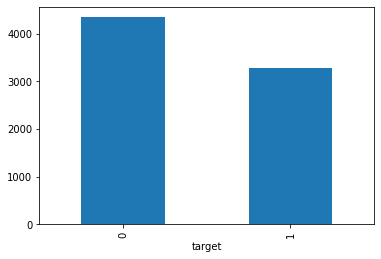

In [16]:
train.groupby('target').text.count().plot.bar(ylim=0)
plt.show()

In [17]:
# Importing HTMLParser
from html.parser import HTMLParser
html_parser = HTMLParser()

In [18]:
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
train['processed_text'] = train['text'].apply(lambda x: html_parser.unescape(x))
test['processed_text'] = test['text'].apply(lambda x: html_parser.unescape(x))

In [165]:
def get_dict(filepath):
    data = pd.read_csv(filepath, header = None, sep = ': ', engine = 'python').rename({0:'key', 1:'value'}, axis = 1)
    data_dict = {data.iloc[i]['key'].replace("\"", "") : data.iloc[i]['value'].replace(',', '').replace("\"", "") for i in range(len(data))}
    return data_dict

def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [167]:
dictionary_filepaths = ['../data/dictionaries/apostrophe_dictionary.txt', '../data/dictionaries/shortword_dictionary.txt', '../data/dictionaries/emoticon_dictionary.txt']
apostrophe_dict, shortword_dict, emoticon_dict = [get_dict(filepath) for filepath in dictionary_filepaths]

In [169]:
train['processed_text'] = train['processed_text'].apply(lambda x: lookup_dict(x,apostrophe_dict)).apply(lambda x: lookup_dict(x,shortword_dict)).apply(lambda x: lookup_dict(x,emoticon_dict))
test['processed_text'] = test['processed_text'].apply(lambda x: lookup_dict(x,apostrophe_dict)).apply(lambda x: lookup_dict(x,shortword_dict)).apply(lambda x: lookup_dict(x,emoticon_dict))

In [173]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
words = stopwords.words("english")

train['processed_text'] = train['text'].apply(lambda x: " ".join([stemmer.stem(i) 
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

test['processed_text'] = test['text'].apply(lambda x: " ".join([stemmer.stem(i) 
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\callu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
import string

#make all words lower case
train['processed_text'] = train['processed_text'].str.lower()
test['processed_text'] = test['processed_text'].str.lower()

#Remove punctuation
table = str.maketrans('', '', string.punctuation)
train['processed_text'] = [train['processed_text'][row].translate(table) for row in range(len(train['processed_text']))]
test['processed_text'] = [test['processed_text'][row].translate(table) for row in range(len(test['processed_text']))]

# remove hash tags
train['processed_text'] = train['processed_text'].str.replace("#", " ")
test['processed_text'] = test['processed_text'].str.replace("#", " ")

#remove words less than 1 character
train['processed_text'] = train['processed_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test['processed_text'] = test['processed_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

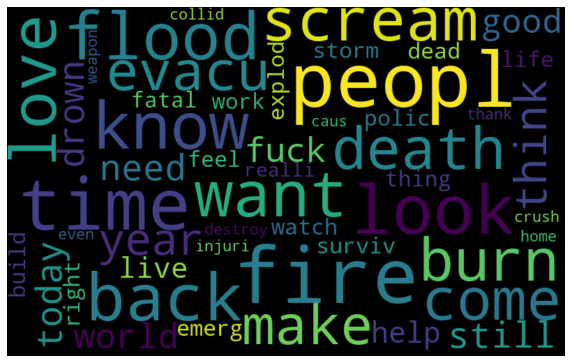

In [176]:
#put frequent words in a mosiac
freq_words = ' '.join([text for text in train['processed_text']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(freq_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [177]:
from collections import Counter
from itertools import chain

# split words into lists
v = train['processed_text'].str.split().tolist() 
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
train['processed_text'] = [' '.join([j for j in i if c[j] > 1]) for i in v]

# split words into lists
v = test['processed_text'].str.split().tolist() 
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
test['processed_text'] = [' '.join([j for j in i if c[j] > 1]) for i in v]

In [182]:
train.head()

,id,keyword,location,text,target,processed_text
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak allah forgiv
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1,forest fire near canada
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1,resid shelter place offic evacu shelter place ...
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1,just sent photo rubi alaska smoke wildfir pour...


In [183]:
#define x, y and t_test
y=train.target
X=train['processed_text']
X_test=test['processed_text']

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.10, random_state=42, shuffle=True)

In [186]:
X_train.shape, X_val.shape, y_train.shape,y_val.shape

((6851,), (762,), (6851,), (762,))

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
train_tfIdf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
val_tfIdf = vectorizer_tfidf.transform(X_val.values.astype('U'))
X_test_tfIdf = vectorizer_tfidf.transform(X_test.values.astype('U'))
print(vectorizer_tfidf.get_feature_names()[:5])

['abandon', 'abbott', 'abbswinston', 'abcnew', 'abia']


In [188]:
train_tfIdf.shape,  val_tfIdf.shape, X_test_tfIdf.shape

((6851, 4530), (762, 4530), (3263, 4530))

In [190]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

model=XGBClassifier(max_depth=6, n_estimators=2000)              #MLPClassifier(early_stopping=True)
model.fit(train_tfIdf, y_train)
#create hyper parameters
penalty=['l1', 'l2']
C=np.logspace(0,4,10)
hyperparameters=dict()   #penalty=penalty, C=C)
#create grid search
clf=GridSearchCV(model, hyperparameters, cv=5, verbose=0)
#fit the model
best_model=clf.fit(train_tfIdf, y_train) # training the model
print(clf.score(train_tfIdf, y_train))

C:\Users\callu\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[11:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\callu\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. 

In [191]:
best_model.predict(val_tfIdf)
print(clf.score(val_tfIdf, y_val))

0.7664041994750657


In [192]:
y_pred=best_model
y_pred = model.predict_proba(val_tfIdf)
y_pred = y_pred >= 0.3
y_pred=y_pred.astype(int)

In [193]:
prediction = model.predict_proba(val_tfIdf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0
prediction_int = prediction_int.astype(np.int)

In [194]:
prediction = model.predict_proba(val_tfIdf) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 then 1 else 0
prediction_int = prediction_int.astype(np.int)

In [195]:
df=pd.DataFrame({'Actual': y_val, 'Predicted':prediction_int})
df

,Actual,Predicted
1224,0,1
7007,0,0
6490,0,0
5337,0,0
38,1,1
...,...,...
5114,1,1
6306,0,0
5605,1,1
896,0,1


In [196]:
test_pred = clf.predict_proba(X_test_tfIdf)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['target'] = test_pred_int
submission = test[['id','target']]
submission.to_csv('../submission/submission.csv', index=False) # writing data to a CSV file
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [209]:
X_train, X_test, X_val = train_tfIdf.toarray(), X_test_tfIdf, val_tfIdf.toarray()

In [210]:
# some model parameters
output_dim = 1
input_dim = X_train.shape[1]

batch_size = 200 
nb_epoch = 100

In [211]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout 
from tensorflow.python.keras.initializers import RandomNormal
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# start building a model
model = Sequential()

model.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
35/35 [==============================] - 1s 8ms/step - loss: 0.6924 - accuracy: 0.4297 - val_loss: 0.6912 - val_accuracy: 0.4291
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.4297 - val_loss: 0.6898 - val_accuracy: 0.4291
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.4297 - val_loss: 0.6886 - val_accuracy: 0.4291
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.4297 - val_loss: 0.6876 - val_accuracy: 0.4291
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.4297 - val_loss: 0.6867 - val_accuracy: 0.4291
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.4297 - val_loss: 0.6860 - val_accuracy: 0.4291
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.4297 - val_loss: 0.6854 - val_accuracy: 0.4291
Epoch 8/100
3

In [218]:
model.summary()
y_pred = model.predict(X_val)

print("Acuracy", accuracy_score(y_val, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 4531      
Total params: 4,531
Trainable params: 4,531
Non-trainable params: 0
_________________________________________________________________
Acuracy 0.42913385826771655
Macro precision_recall_fscore_support
(0.21456692913385828, 0.5, 0.3002754820936639, None)
Micro precision_recall_fscore_support
(0.42913385826771655, 0.42913385826771655, 0.42913385826771655, None)
Weighted precision_recall_fscore_support
(0.18415586831173664, 0.42913385826771655, 0.2577167523481052, None)
C:\Users\callu\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [213]:
input_dim = X_train.shape[1]
hidden_layer_1 = 1560 # input_dim // 3
hidden_layer_2 = 519 # hidden_layer_1 // 3
hidden_layer_3 = 173 # hidden_layer_2 // 3
output_dim = 1 

batch_size = 200 
nb_epoch = 100

In [216]:
model_relu = Sequential()
model_relu.add(Dense(hidden_layer_1, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_2, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0358, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(hidden_layer_3, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.0620, seed=None)))
model_relu.add(Dropout(0.5))
model_relu.add(Dense(1, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.107, seed=None)))

model_relu.summary()

model_relu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_relu.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_val, y_val))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1560)              7068360   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1560)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 519)               810159    
_________________________________________________________________
dropout_7 (Dropout)          (None, 519)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 173)               89960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 173)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [219]:
y_pred = model_relu.predict(X_val)

for i in range(len(y_pred)):
  if y_pred[i][0] >= 0.5:
    y_pred[i][0] = 1
  else:
    y_pred[i][0] = 0

print("Acuracy", accuracy_score(y_val, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

Acuracy 0.7847769028871391
Macro precision_recall_fscore_support
(0.7846176416651385, 0.7727723294316144, 0.7763396212907614, None)
Micro precision_recall_fscore_support
(0.7847769028871391, 0.7847769028871391, 0.7847769028871391, None)
Weighted precision_recall_fscore_support
(0.7847091321543728, 0.7847769028871391, 0.7824965565097398, None)
